# Exploratory Data Analysis

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.visuals import plot_numerical_distribution, plot_categorical_distribution, stacked_bar_churn_ratio, boxplot_by_churn, kdeplot_by_churn, countplot_with_churn

## Data

In [2]:
data = pd.read_csv('../data/cleaned_data.csv')
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


## Feature Prioritization: Selecting Key Column for EDA

In [3]:
# isolate types
categorical_cols = data.select_dtypes(include='object').columns.tolist()
numerical_cols = data.select_dtypes(include='number').columns.tolist()

# Prioritize with feature importance
from sklearn.feature_selection import mutual_info_classif
X = data.drop(columns='Churn')
y = data['Churn']
dummy_df = pd.get_dummies(X)
importances = mutual_info_classif(dummy_df, y)
important_features = pd.Series(importances, index=dummy_df.columns).sort_values(ascending=False)

#Plot only the top 5
top_numerical = [col for col in important_features.index if col in data.columns and data[col].dtype != 'object'][:5]

dummy_to_original = {}
for col in dummy_df.columns:
    for orig_col in X.columns:
        if col.startswith(orig_col + '_'):
            dummy_to_original[col] = orig_col
            break
        elif col == orig_col:  
            dummy_to_original[col] = orig_col
            break

top_categorical = pd.Series(dummy_to_original.values(), index=dummy_to_original.keys())
top_categorical = top_categorical.loc[important_features.index]
top_categorical = top_categorical[top_categorical.isin(X.select_dtypes(include='object').columns)].unique()[:5].tolist()


In [4]:
print(f"selected numerical column: {top_numerical}")
print(f"selected categorical columns: {top_categorical}")

selected numerical column: ['tenure', 'MonthlyCharges', 'TotalCharges', 'PaperlessBilling', 'Dependents']
selected categorical columns: ['Contract', 'TechSupport', 'OnlineSecurity', 'PaymentMethod', 'DeviceProtection']


accordingly, we will perform univariate analysis on the above features

## Univariate Analysis

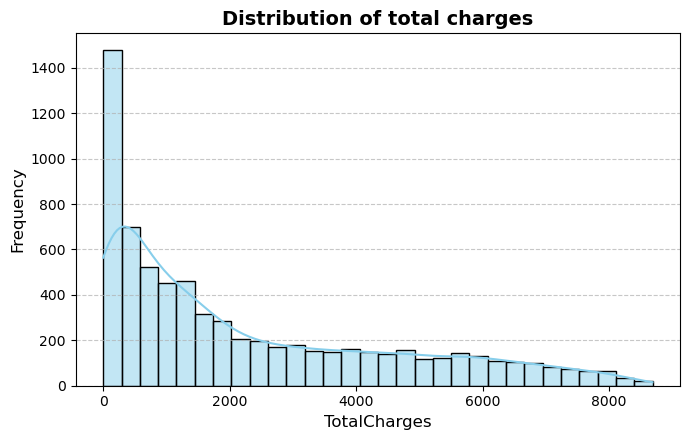

In [5]:
plot_numerical_distribution(data, 'TotalCharges', 'Distribution of total charges')

### Observation
- Highly Right-Skewed Distribution: most customers have **low total charges**
- High frequency of TotalCharges near 0 indicates that most of them are new or short-tenue customer

### Impacts
- Customer Tenure Correlation: Since `TotalCharges = MonthlyCharges × Tenure`, low total charges likely indicate new customers, while high charges suggest long-term loyal customers.
- **Log transformation** can be applied if using model that is sensitive to scale

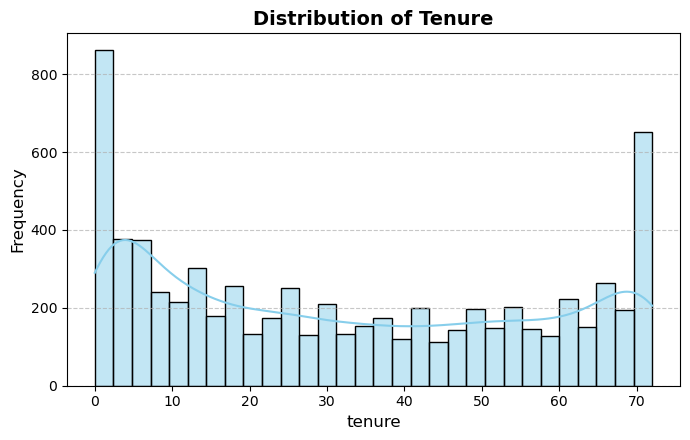

In [6]:
plot_numerical_distribution(data, 'tenure', 'Distribution of Tenure')

### Observations
- A large number of customers are clustered at low tenure (close to 0 months) -> suggest a retention issue? 
- There’s also a noticeable peak at 72 month

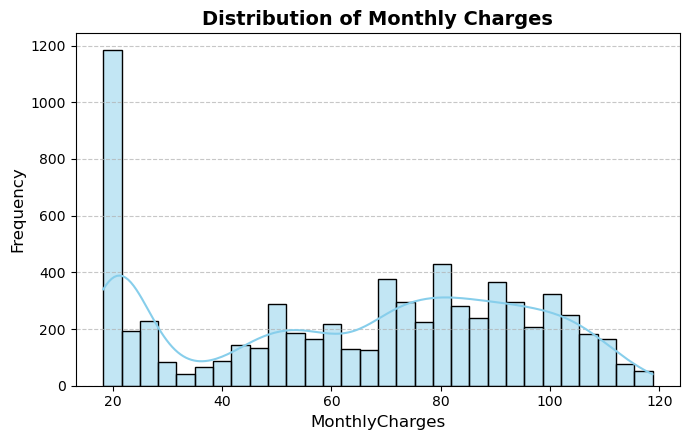

In [7]:
plot_numerical_distribution(data, column='MonthlyCharges', title='Distribution of Monthly Charges')

### Observations
- Most customers pay between 20$ and 80$
- There may be small spikes at round numbers (e.g., $70, $100), suggesting tiered or bundled plans

### Impacts
- Investigate whether high paying customer has more churn rate
- consider engineering spending tier feature

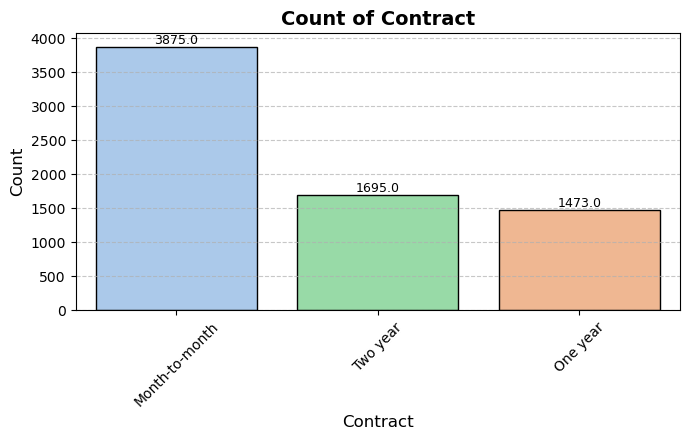

In [8]:
plot_categorical_distribution(data, column='Contract', show_labels=True)

### Observations
- Most customers are on **month-to-month** contracts, followed by one- and two-year plans.  
- Month-to-month contracts may suggest higher churn potential due to flexibility.

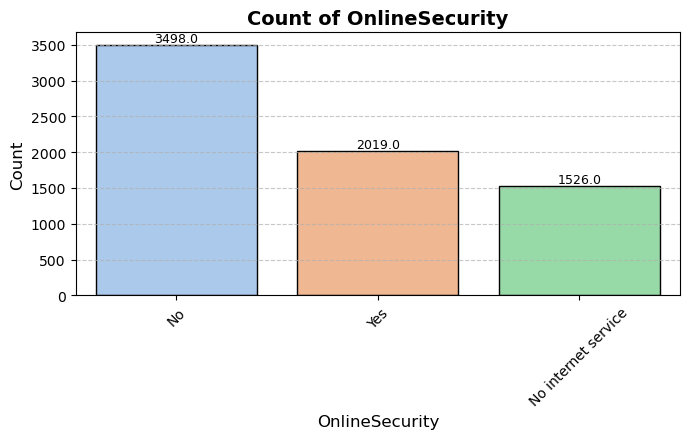

In [9]:
plot_categorical_distribution(data, column='OnlineSecurity', show_labels=True)

### Observation
- A significant number of customers do **not** have online security services.  

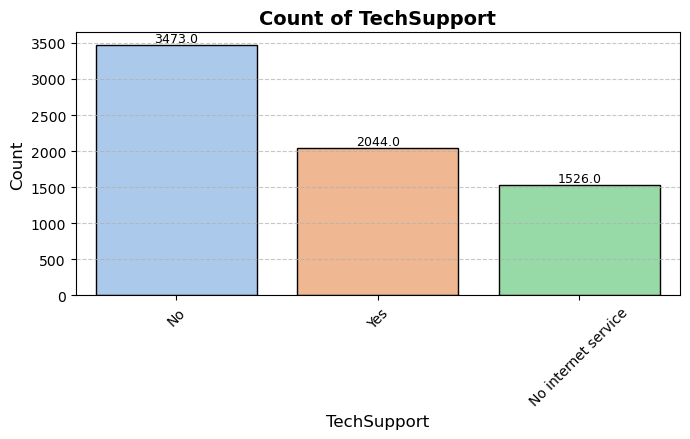

In [10]:
plot_categorical_distribution(data, column='TechSupport', show_labels=True)

### Observaion
- most customers do **not** use technical support -> This might reflect either self-reliance or dissatisfaction with the service

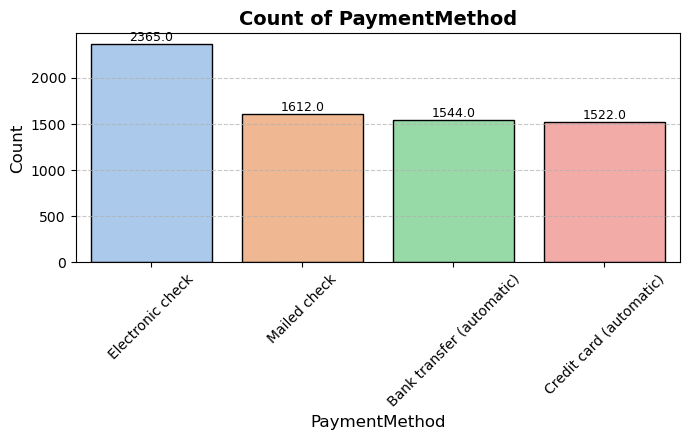

In [11]:
plot_categorical_distribution(data, column='PaymentMethod', show_labels=True)

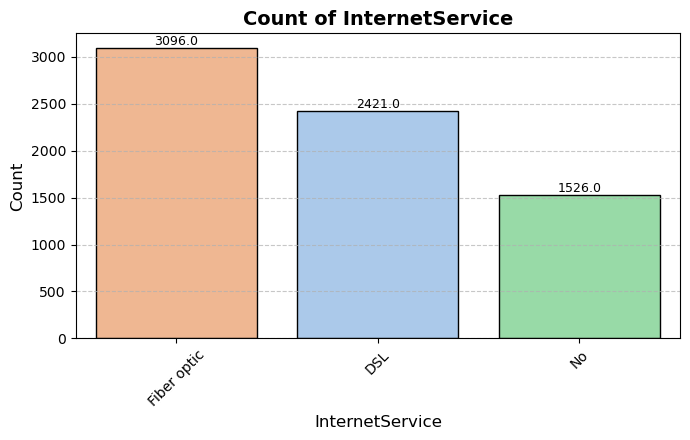

In [12]:
plot_categorical_distribution(data, column='InternetService', show_labels=True)

### Observations
- Majority of customers have **Fiber optic** internet, followed by DSL and None.  
- Fiber optic users may show different churn patterns due to higher expectations.

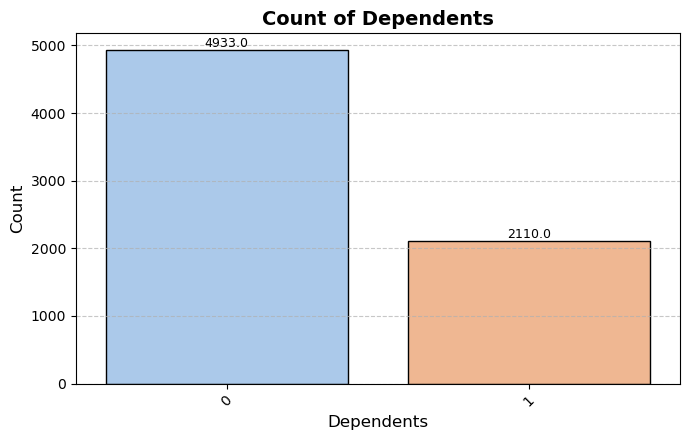

In [13]:
plot_categorical_distribution(data, column='Dependents', show_labels=True)

## Bivariate Analysis (Feature vs Target)

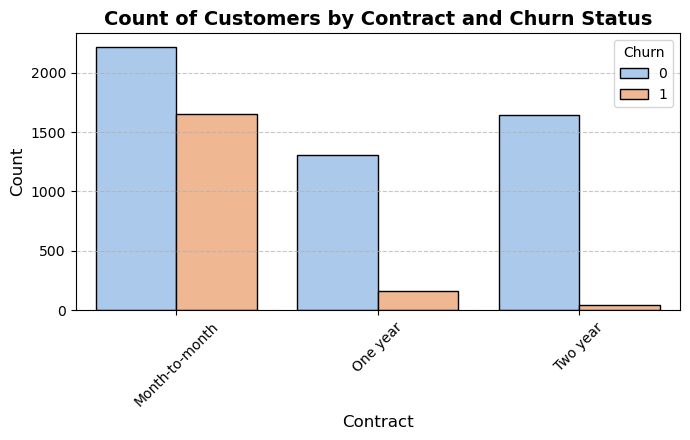

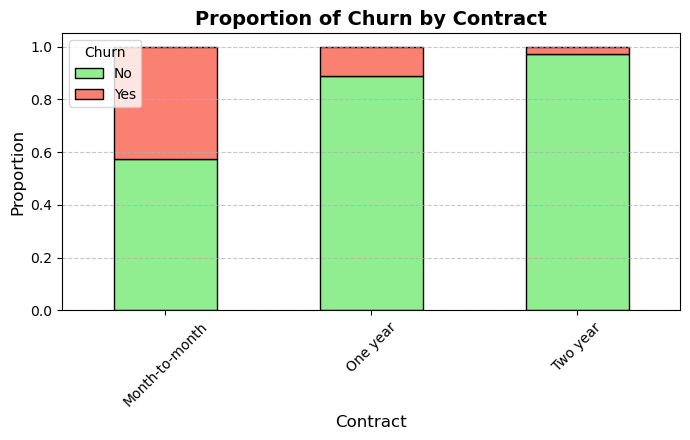

In [26]:
countplot_with_churn(data, column='Contract')
stacked_bar_churn_ratio(data, column='Contract')

### Observations
- Among the three contract types, `Month-to-month` users have the highest churn rate.
- They also make up the majority of the customer base, amplifying their impact on overall churn

short term contract create lower retention -> Retention strategies target this segment could help reduce churn in this segment

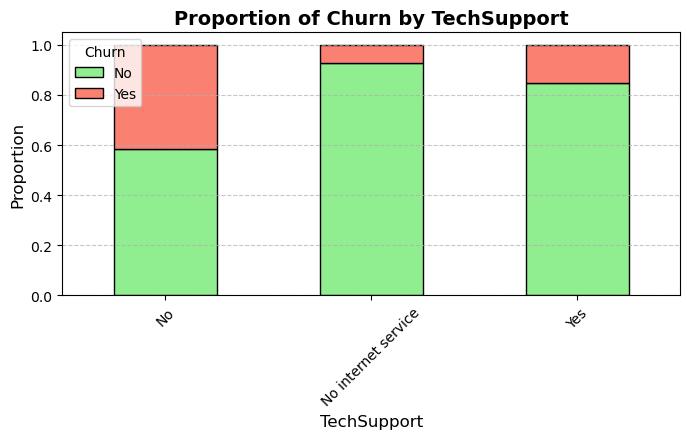

In [17]:
stacked_bar_churn_ratio(data, column='TechSupport')

### Observations
- customers **without Tech Support** churn at much higher rates compared to those with support
- This suggests that offering or promoting Tech Support services could be an effective **retention strategy**

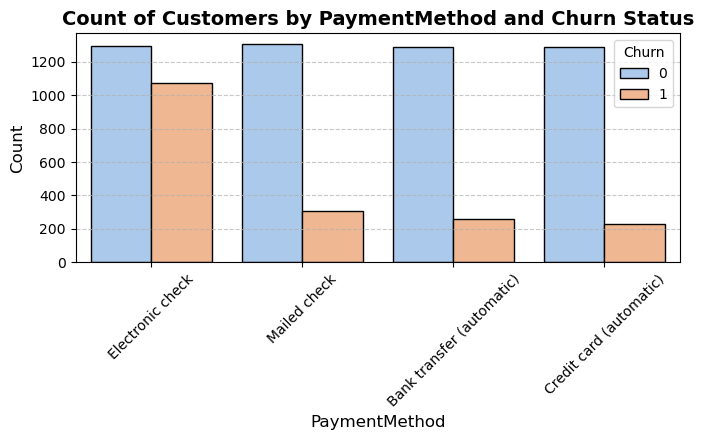

In [27]:
countplot_with_churn(data, column='PaymentMethod')

### Observations
- **Electronic check** users show the **highest churn rate** among all payment methods.
- This may indicate a correlation between **payment flexibility or perceived hassle** and customer retention

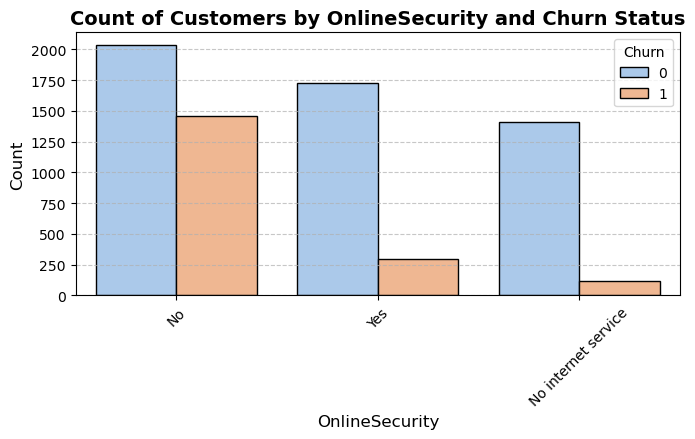

In [25]:
countplot_with_churn(data, column='OnlineSecurity')

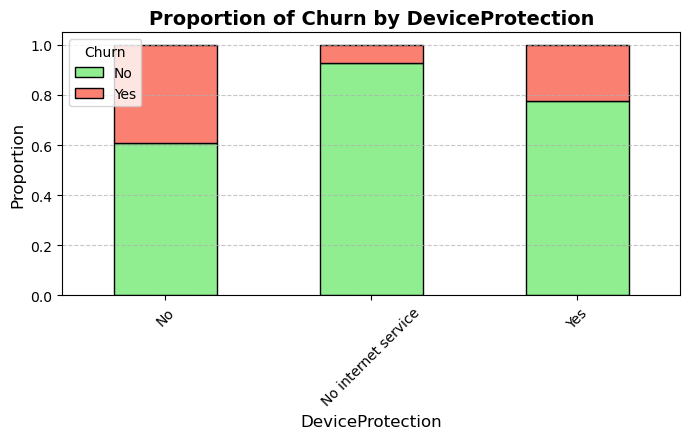

In [30]:
stacked_bar_churn_ratio(data, column='DeviceProtection')

### Observation
- Customers who do not have Online Security have a significantly higher churn rate compared to those who have it (Yes) or those with No internet service

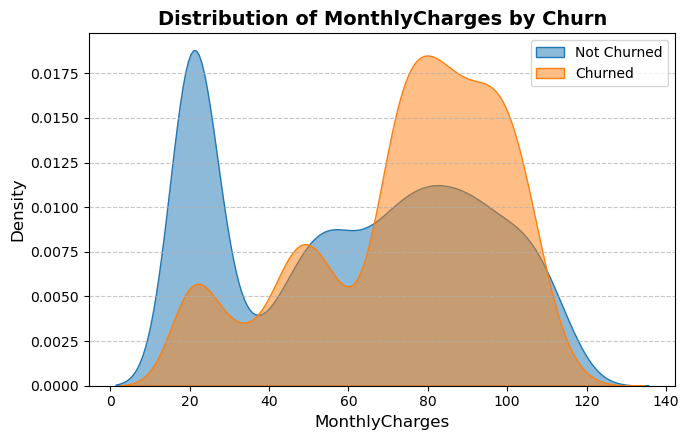

In [22]:
kdeplot_by_churn(data, column='MonthlyCharges')

### Observation
- Churn is higher in customers with moderately high monthly charges (e.g., $70–$100). Low-charge customers tend to churn less

/Users/mewpunyapat/Customer_chern_prediction/utils/visuals.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=column, palette='Set2')


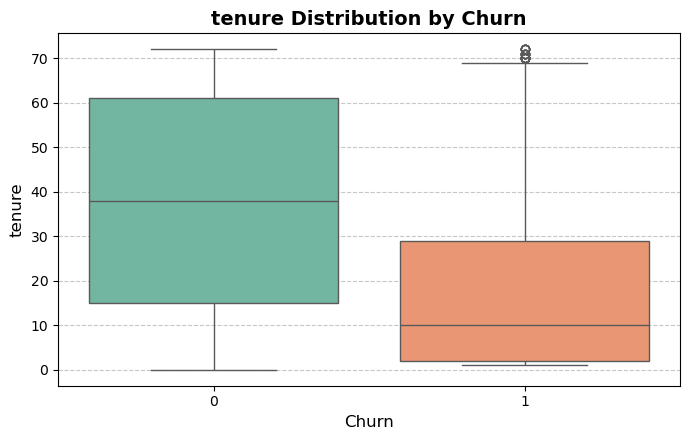

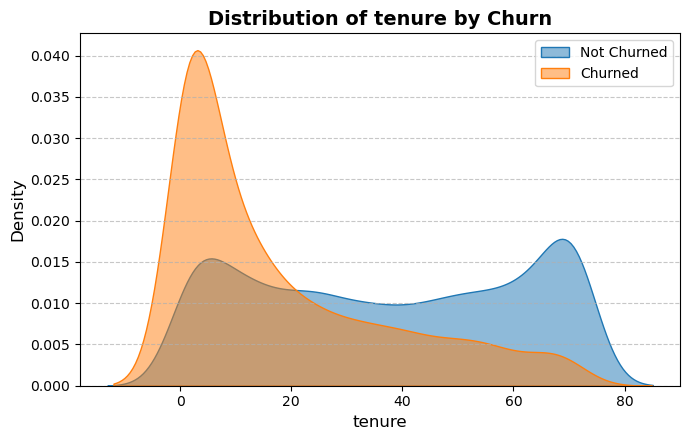

In [38]:
boxplot_by_churn(data, column='tenure')
kdeplot_by_churn(data, column='tenure')

Churn rate is significantly higher among customers with shorter tenure. The median tenure for churned users is much lower than for retained users -> Customers in their early months are more at risk

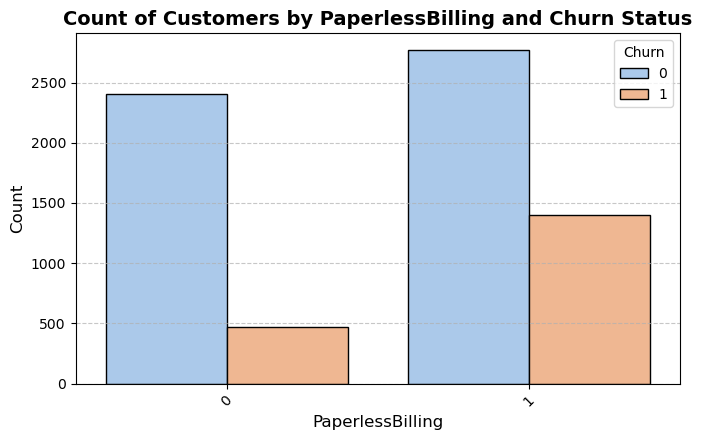

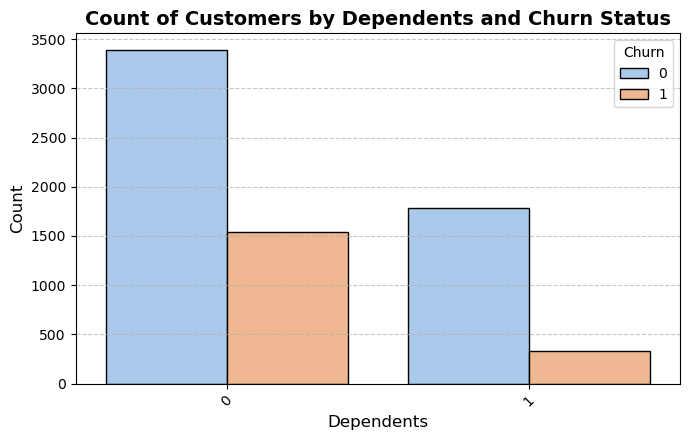

In [34]:
countplot_with_churn(data, column='PaperlessBilling')
countplot_with_churn(data, column='Dependents')

### Observations
- A larger proportion of churned users use paperless billing compared to non-churners
- Customers with dependents churn significantly less than those without

## Multivariate Analysis